<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html week44.do.txt --no_mako -->
<!-- dom:TITLE: Week 44: Dimensionality Reduction, PCA and Clustering. Decision Trees -->

# Week 44: Dimensionality Reduction, PCA and Clustering. Decision Trees
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo and Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University

Date: **Nov 5, 2021**

Copyright 1999-2021, Morten Hjorth-Jensen. Released under CC Attribution-NonCommercial 4.0 license

## Overview of week 44

* Thursday: Wrapping up PCA from last week, Clustering and basics of decision trees, classification and regression algorithms

  * [Video of Lecture](https://www.uio.no/studier/emner/matnat/fys/FYS-STK3155/h21/forelesningsvideoer/LectureNovember4.mp4?vrtx=view-as-webpage)

* Friday: Decision trees, voting models and bagging

**Videos.**

1. [Video on Decision trees](https://www.youtube.com/watch?v=RmajweUFKvM&ab_channel=Simplilearn)

2. [Video on Principal Component Analysis](https://www.youtube.com/watch?v=FgakZw6K1QQ&ab_channel=StatQuestwithJoshStarmer)

3. [Video on Clustering](https://www.youtube.com/watch?v=esmzYhuFnds&ab_channel=MITOpenCourseWare)

**Reading.**

1. Decision Trees: Geron's chapter 6 covers decision trees while ensemble models, voting and bagging are discussed in chapter 7. See also lecture from [STK-IN4300, lecture 7](https://www.uio.no/studier/emner/matnat/math/STK-IN4300/h20/slides/lecture_7.pdf). Chapter 9.2 of Hastie et al contains also a good discussion.

2. Clustering and PCA, see Geron's chapter 8 and [Lecture notes](https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/chapter8.html). Bishop's chapter 9.1 is also a good read.

## Digression First

For those of you interested in the fast growing areas of applications of Machine Learning, this article about [Applications and techniques for fast machine learning in science](https://arxiv.org/abs/2110.13041)  may be interesting.

It has several interesting perspectives and highly interesting
applications that link scientific discoveries with efficient software
and hardware. The emphasis is onintegrating power Machine Learning
methods into the real-time experimental data processing loop to
accelerate scientific discovery.

## A short Discussion of Project 2

For neural networks and regression, should I use a design matrix with information about a polynomial fit or not?
Discuss pros and cons. The example here shows some of these issues.

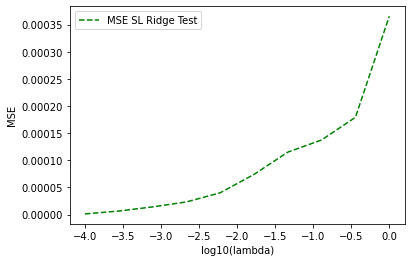

/Users/mhjensen/Software/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mhjensen/Software/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mhjensen/Software/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mhjensen/Software/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warning

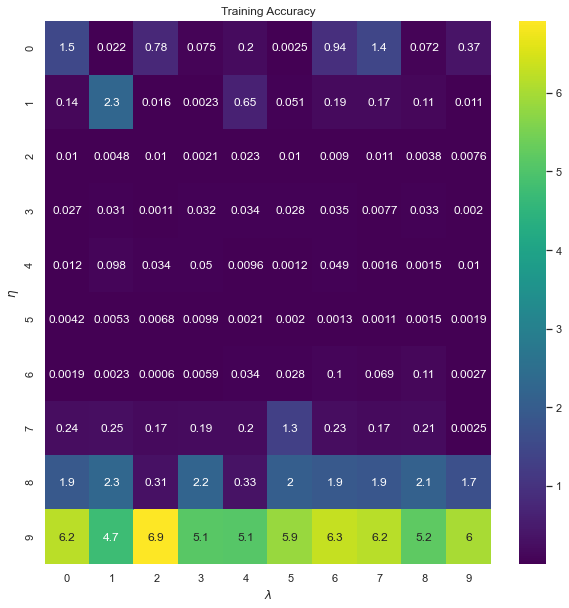

/Users/mhjensen/Software/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mhjensen/Software/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mhjensen/Software/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mhjensen/Software/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warning

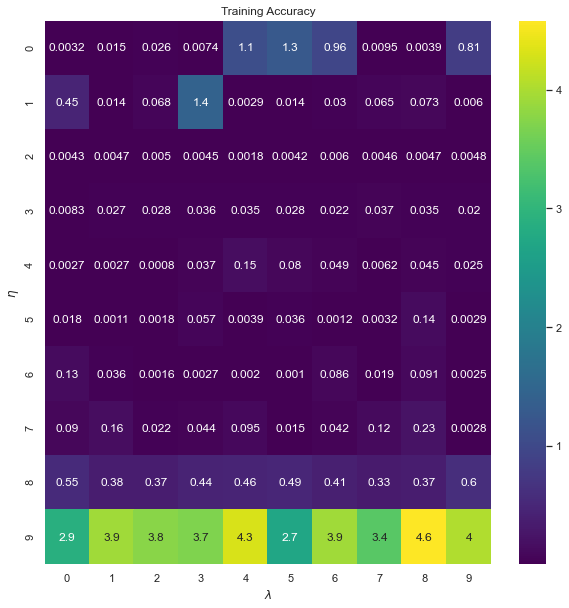

In [1]:
%matplotlib inline

"""
Code to test Ridge and NNs using Scikit-Learn only
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
import seaborn as sns


def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n
# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(315)

n = 100
x = np.random.rand(n)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)

Maxpolydegree = 5
X = np.zeros((n,Maxpolydegree-1))

for degree in range(1,Maxpolydegree): #No intercept column
    X[:,degree-1] = x**(degree)

# We split the data in test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Decide which values of lambda to use

nlambdas = 10
lmbd_vals = np.logspace(-4, 0, nlambdas)
MSERidgePredict = np.zeros(nlambdas)
for i in range(nlambdas):
    lmb = lmbd_vals[i]
    RegRidge = linear_model.Ridge(lmb)
    RegRidge.fit(X_train,y_train)
    ypredictRidge = RegRidge.predict(X_test)
    MSERidgePredict[i] = MSE(y_test,ypredictRidge)

plt.figure()
plt.plot(np.log10(lmbd_vals), MSERidgePredict, 'g--', label = 'MSE SL Ridge Test')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Neural Network part

n_hidden_neurons = 50
epochs = 100
# store models for later use
eta_vals = np.logspace(-4, 0, 10)
# store the models for later use
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
sns.set()
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(X_train, y_train)
        ypredictMLP = dnn.predict(X_test)
        test_accuracy[i][j] = MSE(ypredictMLP, y_test)

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

# Now we redefine our design matrix to include only the x-values and try out our NN

X = np.zeros((n,1))
X[:,0] = x

# We split the data in test and training data again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Repeat the NN calculation
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
sns.set()
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(X_train, y_train)
        ypredictMLP = dnn.predict(X_test)
        test_accuracy[i][j] = MSE(ypredictMLP, y_test)

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

## Learning Rate and more

When developing your own gradient descent code, it is useful to test
it first on a standard ordinary least squares problem. Then the
Hessian matrix is determined by the design matrix only, namely
$\boldsymbol{H}\propto \boldsymbol{X}^T\boldsymbol{X}$.

The optimal learning rate is determined by the inverse of the largest
eigenvalue of $\boldsymbol{H}$. This can be used as a guideline for the
learning rate guess.

Keeping this fixed, can aid in studyng the dependence on say the mean
square value for OLS as function of the number of batches and epochs
in your stochastic gradient descent code. See for example the code
examples for week 40 (right before the neural network material).

## Thursday, Principal Component Analysis

For the principal component analysis, 
see slides from [week 43](https://compphysics.github.io/MachineLearning/doc/pub/week43/html/week43-reveal.html), in particular from slide 28 and forward

## A kind of Bird's view  on PCA

**Why do we maximize variance during Principal Component Analysis?**

Variance is a measure of the *variability* of the data you
have. Potentially the number of components is infinite, so you want to "squeeze" the most
information in each component of the finite set you build.

If, to exaggerate, you were to select a single principal component,
you would want it to account for the most variability possible: hence
the search for maximum variance, so that the one component collects
the most "uniqueness" from the data set.

Maximizing the component vector variances is the same as maximizing
the 'uniqueness' of those vectors. The vectors are as distant
from each other as possible (orthogonal to each other).

Take for example a situation where you have 2 lines that are
orthogonal in a 3D space. You can capture the environment much more
completely with those orthogonal lines than 2 lines that are parallel
(or nearly parallel). When applied to very high dimensional states
using very few vectors, this becomes a much more important
relationship among the vectors to maintain. In a linear algebra sense
you want independent rows to be produced by PCA, otherwise some of
those rows will be redundant.

## Thursday: Clustering and Unsupervised Learning

In general terms cluster analysis, or clustering, is the task of grouping a
data-set into different distinct categories based on some measure of equality of
the data. This measure is often referred to as a **metric** or **similarity
measure** in the literature (note: sometimes we deal with a **dissimilarity
measure** instead). Usually, these metrics are formulated as some kind of
distance function between points in a high-dimensional space.

The simplest, and also the most
common is the **Euclidean distance**.

## Basic Idea of the $k$-means Clustering Algorithm

The simplest of all clustering algorithms is the  **k-means algorithm**
, sometimes also referred to as *Lloyds algorithm*. It is the simplest and also
the most common. From its simplicity it obtains both strengths and weaknesses.
These will be discussed in more detail later. The $k$-means algorithm is a
**centroid based** clustering algorithm.

## The $k$-means Algorithm

Assume, we are given $n$ data points and we wish to split the data into $K < n$
different categories, or clusters. We label each cluster by an integer

$$
k\in\{1, \cdots, K \}.
$$

In the basic k-means algorithm each point is assigned to only
one cluster $k$, and these assignments are *non-injective* i.e. many-to-one. We
can think of these mappings as an encoder $k = C(i)$, which assigns the $i$-th
data-point $\bf x_i$ to the $k$-th cluster.

$k$-means algorithm in words:
1. We start with guesses / random initializations of our $k$ cluster centers/centroids

2. For each centroid the points that are most similar are identified

3. Then we move / replace each centroid with a coordinate average of all the points that were assigned to that centroid.

4. Iterate 2-3 until the centroids no longer move (to some tolerance)

## Basic Math of the $k$-means Algorithm

We assume we have $n$ data-points

<!-- Equation labels as ordinary links -->
<div id="eq:kmeanspoints"></div>

$$
\begin{equation}\label{eq:kmeanspoints} \tag{1}
  \boldsymbol{x_i}  = \{x_{i, 1}, \cdots, x_{i, p}\}\in\mathbb{R}^p.
\end{equation}
$$

which we wish to group into $K < n$ clusters. For our dissimilarity measure we
use the *squared Euclidean distance*

<!-- Equation labels as ordinary links -->
<div id="eq:squaredeuclidean"></div>

$$
\begin{equation}\label{eq:squaredeuclidean} \tag{2}
  d(\boldsymbol{x_i}, \boldsymbol{x_i'}) = \sum_{j=1}^p(x_{ij} - x_{i'j})^2
                         = ||\boldsymbol{x_i} - \boldsymbol{x_{i'}}||^2
\end{equation}
$$

## Within Cluster Point Scatter

We define the so called *within-cluster point scatter* which gives us a
measure of how close each data point assigned to the same cluster tends to be to
the all the others.

<!-- Equation labels as ordinary links -->
<div id="eq:withincluster"></div>

$$
\begin{equation}\label{eq:withincluster} \tag{3}
  W(C) = \frac{1}{2}\sum_{k=1}^K\sum_{C(i)=k}
          \sum_{C(i')=k}d(\boldsymbol{x_i}, \boldsymbol{x_{i'}}) =
          \sum_{k=1}^KN_k\sum_{C(i)=k}||\boldsymbol{x_i} - \boldsymbol{\overline{x_k}}||^2
\end{equation}
$$

where $\boldsymbol{\overline{x_k}}$ is the mean vector associated with the $k$-th
cluster, and $N_k = \sum_{i=1}^nI(C(i) = k)$, where the $I()$ notation is
similar to the Kronecker delta (*Commonly used in statistics, it just means that
when $i = k$ we have the encoder $C(i)$*). In other words,  the within-cluster
scatter measures the compactness of each cluster with respect to the data points
assigned to each cluster. This is the quantity that the $k$-means algorithm aims
to minimize. We refer to this quantity $W(C)$ as the within cluster scatter
because of its relation to the *total scatter*.

## More Details

We have

<!-- Equation labels as ordinary links -->
<div id="eq:totalscatter"></div>

$$
\begin{equation}\label{eq:totalscatter} \tag{4}
  T = W(C) + B(C) = \frac{1}{2}\sum_{i=1}^n
                    \sum_{i'=1}^nd(\boldsymbol{x_i}, \boldsymbol{x_{i'}})
                  = \frac{1}{2}\sum_{k=1}^K\sum_{C(i)=k}
                    \Big(\sum_{C(i') = k}d(\boldsymbol{x_i}, \boldsymbol{x_{i'}})
                  + \sum_{C(i')\neq k}d(\boldsymbol{x_i}, \boldsymbol{x_{i'}})\Big).
\end{equation}
$$

This is a quantity that is conserved throughout the $k$-means algorithm. It can
be thought of as the total amount of information in the data, and it is composed
of the aforementioned within-cluster scatter and the *between-cluster scatter*
$B(C)$. In methods such as principle component analysis the total scatter is not
conserved.

## Total Cluster Variance
Given a cluster mean $\boldsymbol{m_k}$ we define the **total cluster variance**

<!-- Equation labels as ordinary links -->
<div id="eq:totalclustervariance"></div>

$$
\begin{equation}\label{eq:totalclustervariance} \tag{5}
  \min_{C, \{\boldsymbol{m_k}\}_1^K}\sum_{k=1}^KN_k\sum||\boldsymbol{x_i} - \boldsymbol{m_k}||^2
\end{equation}
$$

Now we have all the pieces necessary to formally revisit the $k$-means algorithm.

## The $k$-means Clustering Algorithm

The $k$-means clustering algorithm goes as follows 

1. For a given cluster assignment $C$, and $k$ cluster means $\left\{m_1, \cdots, m_k\right\}$. We minimize the total cluster variance with respect to the cluster means $\{m_k\}$ yielding the means of the currently assigned clusters.

2. Given a current set of $k$ means $\{m_k\}$ the total cluster variance is minimized by assigning each observation to the closest (current) cluster mean. That is $$C(i) = \underset{1\leq k\leq K}{\mathrm{argmin}} ||\boldsymbol{x_i} - \boldsymbol{m_k}||^2$$

3. Steps 1 and 2 are repeated until the assignments do not change.

## Summarizing

1. Before we start we specify a number $k$ which is the number of clusters we want to try to separate our data into.

2. We initially choose $k$ random data points in our data as our initial centroids, *or means* (this is where the name comes from).

3. Assign each data point to their closest centroid, based on the squared Euclidean distance.

4. For each of the $k$ cluster we update the centroid by calculating new mean values for all the data points in the cluster.

5. Iteratively minimize the within cluster scatter by performing steps (3, 4) until the new assignments stop changing (can be to some tolerance) or until a maximum number of iterations have passed.

## Writing our own Code, the Data Set

Let us now program the most basic version of the algorithm using nothing but
Python with numpy arrays. This code is kept intentionally simple to gradually
progress our understanding. There is no vectorization of any kind, and even most
helper functions are not utilized.

We need first a dataset to do our cluster analysis on. In our case
this is a plain *vanilla* data set using random numbers using a
Gaussian distribution.

In [2]:
import time
import numpy as np
import tensorflow as tf
from matplotlib import image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from IPython.display import display

np.random.seed(2021)

Next we define functions, for ease of use later, to generate Gaussians and to
set up our toy data set.

In [3]:
def gaussian_points(dim=2, n_points=1000, mean_vector=np.array([0, 0]),
                    sample_variance=1):
    """
    Very simple custom function to generate gaussian distributed point clusters
    with variable dimension, number of points, means in each direction
    (must match dim) and sample variance.

    Inputs:
        dim (int)
        n_points (int)
        mean_vector (np.array) (where index 0 is x, index 1 is y etc.)
        sample_variance (float)

    Returns:
        data (np.array): with dimensions (dim x n_points)
    """

    mean_matrix = np.zeros(dim) + mean_vector
    covariance_matrix = np.eye(dim) * sample_variance
    data = np.random.multivariate_normal(mean_matrix, covariance_matrix,
                                    n_points)
    return data



def generate_simple_clustering_dataset(dim=2, n_points=1000, plotting=True,
                                    return_data=True):
    """
    Toy model to illustrate k-means clustering
    """

    data1 = gaussian_points(mean_vector=np.array([5, 5]))
    data2 = gaussian_points()
    data3 = gaussian_points(mean_vector=np.array([1, 4.5]))
    data4 = gaussian_points(mean_vector=np.array([5, 1]))
    data = np.concatenate((data1, data2, data3, data4), axis=0)

    if plotting:
        fig, ax = plt.subplots()
        ax.scatter(data[:, 0], data[:, 1], alpha=0.2)
        ax.set_title('Toy Model Dataset')
        plt.show()


    if return_data:
        return data


data = generate_simple_clustering_dataset()

## Implementing the $k$-means Algorithm

With the above dataset we start
implementing the $k$-means algorithm.

In [4]:

n_samples, dimensions = data.shape
n_clusters = 4

# we randomly initialize our centroids
np.random.seed(2021)
centroids = data[np.random.choice(n_samples, n_clusters, replace=False), :]
distances = np.zeros((n_samples, n_clusters))

# first we need to calculate the distance to each centroid from our data
for k in range(n_clusters):
    for n in range(n_samples):
        dist = 0
        for d in range(dimensions):
            dist += np.abs(data[n, d] - centroids[k, d])**2
            distances[n, k] = dist

# we initialize an array to keep track of to which cluster each point belongs
# the way we set it up here the index tracks which point and the value which
# cluster the point belongs to
cluster_labels = np.zeros(n_samples, dtype='int')

# next we loop through our samples and for every point assign it to the cluster
# to which it has the smallest distance to
for n in range(n_samples):
    # tracking variables (all of this is basically just an argmin)
    smallest = 1e10
    smallest_row_index = 1e10
    for k in range(n_clusters):
        if distances[n, k] < smallest:
            smallest = distances[n, k]
            smallest_row_index = k

    cluster_labels[n] = smallest_row_index

## Plotting

In [5]:
fig = plt.figure()
ax = fig.add_subplot()
unique_cluster_labels = np.unique(cluster_labels)
for i in unique_cluster_labels:
    ax.scatter(data[cluster_labels == i, 0],
               data[cluster_labels == i, 1],
               label = i,
               alpha = 0.2)
    ax.scatter(centroids[:, 0], centroids[:, 1], c='black')

ax.set_title("First Grouping of Points to Centroids")

plt.show()

So what do we have so far? We have 'picked' $k$ centroids at random from our
data points. There are other ways of more intelligently choosing their
initializations, however for our purposes randomly is fine. Then we have
initialized an array 'distances' which holds the information of the distance,
*or dissimilarity*, of every point to of our centroids. Finally, we have
initialized an array 'cluster_labels' which according to our distances array
holds the information of to which centroid every point is assigned. This was the
first pass of our algorithm. Essentially, all we need to do now is repeat the
distance and assignment steps above until we have reached a desired convergence
or a maximum amount of iterations.

## Continuing

In [6]:

max_iterations = 100
tolerance = 1e-8

for iteration in range(max_iterations):
    prev_centroids = centroids.copy()
    for k in range(n_clusters):
        # this array will be used to update our centroid positions
        vector_mean = np.zeros(dimensions)
        mean_divisor = 0
        for n in range(n_samples):
            if cluster_labels[n] == k:
                vector_mean += data[n, :]
                mean_divisor += 1

        # update according to the k means
        centroids[k, :] = vector_mean / mean_divisor

    # we find the dissimilarity
    for k in range(n_clusters):
        for n in range(n_samples):
            dist = 0
            for d in range(dimensions):
                dist += np.abs(data[n, d] - centroids[k, d])**2
                distances[n, k] = dist

    # assign each point
    for n in range(n_samples):
        smallest = 1e10
        smallest_row_index = 1e10
        for k in range(n_clusters):
            if distances[n, k] < smallest:
                smallest = distances[n, k]
                smallest_row_index = k

        cluster_labels[n] = smallest_row_index

    # convergence criteria
    centroid_difference = np.sum(np.abs(centroids - prev_centroids))
    if centroid_difference < tolerance:
        print(f'Converged at iteration {iteration}')
        break

    elif iteration == max_iterations:
        print(f'Did not converge in {max_iterations} iterations')

## Wrapping it up
We now have a simple , un-optimized $k$-means
clustering implementation. Lets plot the final result

In [7]:
fig = plt.figure()
ax = fig.add_subplot()
unique_cluster_labels = np.unique(cluster_labels)
for i in unique_cluster_labels:
    ax.scatter(data[cluster_labels == i, 0],
               data[cluster_labels == i, 1],
               label = i,
               alpha = 0.2)
    ax.scatter(centroids[:, 0], centroids[:, 1], c='black')

ax.set_title("Final Result of K-means Clustering")

plt.show()

In [8]:
def naive_kmeans(data, n_clusters=4, max_iterations=100, tolerance=1e-8):
    start_time = time.time()

    n_samples, dimensions = data.shape
    n_clusters = 4
    #np.random.seed(2021)
    centroids = data[np.random.choice(n_samples, n_clusters, replace=False), :]
    distances = np.zeros((n_samples, n_clusters))

    for k in range(n_clusters):
        for n in range(n_samples):
            dist = 0
            for d in range(dimensions):
                dist += np.abs(data[n, d] - centroids[k, d])**2
                distances[n, k] = dist

    cluster_labels = np.zeros(n_samples, dtype='int')

    for n in range(n_samples):
        smallest = 1e10
        smallest_row_index = 1e10
        for k in range(n_clusters):
            if distances[n, k] < smallest:
                smallest = distances[n, k]
                smallest_row_index = k

        cluster_labels[n] = smallest_row_index

    for iteration in range(max_iterations):
        prev_centroids = centroids.copy()
        for k in range(n_clusters):
            vector_mean = np.zeros(dimensions)
            mean_divisor = 0
            for n in range(n_samples):
                if cluster_labels[n] == k:
                    vector_mean += data[n, :]
                    mean_divisor += 1

            centroids[k, :] = vector_mean / mean_divisor

        for k in range(n_clusters):
            for n in range(n_samples):
                dist = 0
                for d in range(dimensions):
                    dist += np.abs(data[n, d] - centroids[k, d])**2
                    distances[n, k] = dist

        for n in range(n_samples):
            smallest = 1e10
            smallest_row_index = 1e10
            for k in range(n_clusters):
                if distances[n, k] < smallest:
                    smallest = distances[n, k]
                    smallest_row_index = k

            cluster_labels[n] = smallest_row_index

        centroid_difference = np.sum(np.abs(centroids - prev_centroids))
        if centroid_difference < tolerance:
            print(f'Converged at iteration {iteration}')
            print(f'Runtime: {time.time() - start_time} seconds')

            return cluster_labels, centroids

    print(f'Did not converge in {max_iterations} iterations')
    print(f'Runtime: {time.time() - start_time} seconds')

    return cluster_labels, centroids

## Decision trees, overarching aims

We start here with the most basic algorithm, the so-called decision
tree. With this basic algorithm we can in turn build more complex
networks, spanning from homogeneous and heterogenous forests (bagging,
random forests and more) to one of the most popular supervised
algorithms nowadays, the extreme gradient boosting, or just
XGBoost. But let us start with the simplest possible ingredient.

Decision trees are supervised learning algorithms used for both,
classification and regression tasks.

The main idea of decision trees
is to find those descriptive features which contain the most
**information** regarding the target feature and then split the dataset
along the values of these features such that the target feature values
for the resulting underlying datasets are as pure as possible.

The descriptive features which reproduce best the target/output features are normally  said
to be the most informative ones. The process of finding the **most
informative** feature is done until we accomplish a stopping criteria
where we then finally end up in so called **leaf nodes**.

## Basics of a tree

A decision tree is typically divided into a **root node**, the **interior nodes**,
and the final **leaf nodes** or just **leaves**. These entities are then connected by so-called **branches**.

The leaf nodes
contain the predictions we will make for new query instances presented
to our trained model. This is possible since the model has 
learned the underlying structure of the training data and hence can,
given some assumptions, make predictions about the target feature value
(class) of unseen query instances.

## A Sketch of a Tree, Regression problem

<!-- FIGURE: [DataFiles/Regsimpletree.png, width=600 frac=0.8] -->

## A Sketch of a Tree, Classification  problem

<!-- FIGURE: [DataFiles/Classimpletree.png, width=600 frac=0.8] -->

## A typical Decision Tree with its pertinent Jargon, Classification Problem

<!-- dom:FIGURE: [DataFiles/cancer.png, width=600 frac=0.8] -->
<!-- begin figure -->

<img src="DataFiles/cancer.png" width="600"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

This tree was produced using the Wisconsin cancer data (discussed here as well, see code examples below) using **Scikit-Learn**'s decision tree classifier. Here we have used the so-called **gini** index (see below) to split the various branches.

## General Features

The overarching approach to decision trees is a top-down approach.

* A leaf provides the classification of a given instance.

* A node specifies a test of some attribute of the instance.

* A branch corresponds to a possible values of an attribute.

* An instance is classified by starting at the root node of the tree, testing the attribute specified by this node, then moving down the tree branch corresponding to the value of the attribute in the given example.

This process is then repeated for the subtree rooted at the new
node.

## How do we set it up?

In simplified terms, the process of training a decision tree and
predicting the target features of query instances is as follows:

1. Present a dataset containing of a number of training instances characterized by a number of descriptive features and a target feature

2. Train the decision tree model by continuously splitting the target feature along the values of the descriptive features using a measure of information gain during the training process

3. Grow the tree until we accomplish a stopping criteria create leaf nodes which represent the *predictions* we want to make for new query instances

4. Show query instances to the tree and run down the tree until we arrive at leaf nodes

Then we are essentially done!

## Decision trees and Regression

2nd degree coefficients:
zero power:  -1.0213890400311119
first power:  0.18014254613327288
second power:  -0.0005133239735522407


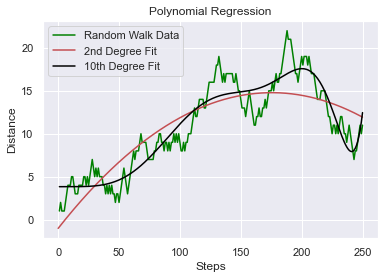

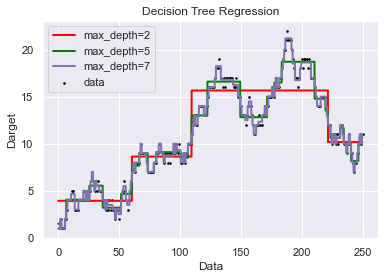

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

steps=250

distance=0
x=0
distance_list=[]
steps_list=[]
while x<steps:
    distance+=np.random.randint(-1,2)
    distance_list.append(distance)
    x+=1
    steps_list.append(x)
plt.plot(steps_list,distance_list, color='green', label="Random Walk Data")

steps_list=np.asarray(steps_list)
distance_list=np.asarray(distance_list)

X=steps_list[:,np.newaxis]

#Polynomial fits

#Degree 2
poly_features=PolynomialFeatures(degree=2, include_bias=False)
X_poly=poly_features.fit_transform(X)

lin_reg=LinearRegression()
poly_fit=lin_reg.fit(X_poly,distance_list)
b=lin_reg.coef_
c=lin_reg.intercept_
print ("2nd degree coefficients:")
print ("zero power: ",c)
print ("first power: ", b[0])
print ("second power: ",b[1])

z = np.arange(0, steps, .01)
z_mod=b[1]*z**2+b[0]*z+c

fit_mod=b[1]*X**2+b[0]*X+c
plt.plot(z, z_mod, color='r', label="2nd Degree Fit")
plt.title("Polynomial Regression")

plt.xlabel("Steps")
plt.ylabel("Distance")

#Degree 10
poly_features10=PolynomialFeatures(degree=10, include_bias=False)
X_poly10=poly_features10.fit_transform(X)

poly_fit10=lin_reg.fit(X_poly10,distance_list)

y_plot=poly_fit10.predict(X_poly10)
plt.plot(X, y_plot, color='black', label="10th Degree Fit")

plt.legend()
plt.show()


#Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor
regr_1=DecisionTreeRegressor(max_depth=2)
regr_2=DecisionTreeRegressor(max_depth=5)
regr_3=DecisionTreeRegressor(max_depth=9)
regr_1.fit(X, distance_list)
regr_2.fit(X, distance_list)
regr_3.fit(X, distance_list)

X_test = np.arange(0.0, steps, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
y_3=regr_3.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, distance_list, s=2.5, c="black", label="data")
plt.plot(X_test, y_1, color="red",
         label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="green", label="max_depth=5", linewidth=2)
plt.plot(X_test, y_3, color="m", label="max_depth=7", linewidth=2)

plt.xlabel("Data")
plt.ylabel("Darget")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

## Building a tree, regression

There are mainly two steps
1. We split the predictor space (the set of possible values $x_1,x_2,\dots, x_p$) into $J$ distinct and non-non-overlapping regions, $R_1,R_2,\dots,R_J$.  

2. For every observation that falls into the region $R_j$ , we make the same prediction, which is simply the mean of the response values for the training observations in $R_j$.

How do we construct the regions $R_1,\dots,R_J$?  In theory, the
regions could have any shape. However, we choose to divide the
predictor space into high-dimensional rectangles, or boxes, for
simplicity and for ease of interpretation of the resulting predictive
model. The goal is to find boxes $R_1,\dots,R_J$ that minimize the
MSE, given by

$$
\sum_{j=1}^J\sum_{i\in R_j}(y_i-\overline{y}_{R_j})^2,
$$

where $\overline{y}_{R_j}$  is the mean response for the training observations 
within box $j$.

## A top-down approach, recursive binary splitting

Unfortunately, it is computationally infeasible to consider every
possible partition of the feature space into $J$ boxes.  The common
strategy is to take a top-down approach

The approach is top-down because it begins at the top of the tree (all
observations belong to a single region) and then successively splits
the predictor space; each split is indicated via two new branches
further down on the tree. It is greedy because at each step of the
tree-building process, the best split is made at that particular step,
rather than looking ahead and picking a split that will lead to a
better tree in some future step.

## Making a tree

In order to implement the recursive binary splitting we start by selecting
the predictor $x_j$ and a cutpoint $s$ that splits the predictor space into two regions $R_1$ and $R_2$

$$
\left\{X\vert x_j < s\right\},
$$

and

$$
\left\{X\vert x_j \geq s\right\},
$$

so that we obtain the lowest MSE, that is

$$
\sum_{i:x_i\in R_j}(y_i-\overline{y}_{R_1})^2+\sum_{i:x_i\in R_2}(y_i-\overline{y}_{R_2})^2,
$$

which we want to minimize by considering all predictors
$x_1,x_2,\dots,x_p$.  We consider also all possible values of $s$ for
each predictor. These values could be determined by randomly assigned
numbers or by starting at the midpoint and then proceed till we find
an optimal value.

For any $j$ and $s$, we define the pair of half-planes where
$\overline{y}_{R_1}$ is the mean response for the training
observations in $R_1(j,s)$, and $\overline{y}_{R_2}$ is the mean
response for the training observations in $R_2(j,s)$.

Finding the values of $j$ and $s$ that minimize the above equation can be
done quite quickly, especially when the number of features $p$ is not
too large.

Next, we repeat the process, looking
for the best predictor and best cutpoint in order to split the data
further so as to minimize the MSE within each of the resulting
regions. However, this time, instead of splitting the entire predictor
space, we split one of the two previously identified regions. We now
have three regions. Again, we look to split one of these three regions
further, so as to minimize the MSE. The process continues until a
stopping criterion is reached; for instance, we may continue until no
region contains more than five observations.

## Pruning the tree

The above procedure is rather straightforward, but leads often to
overfitting and unnecessarily large and complicated trees. The basic
idea is to grow a large tree $T_0$ and then prune it back in order to
obtain a subtree. A smaller tree with fewer splits (fewer regions) can
lead to smaller variance and better interpretation at the cost of a
little more bias.

The so-called Cost complexity pruning algorithm gives us a
way to do just this. Rather than considering every possible subtree,
we consider a sequence of trees indexed by a nonnegative tuning
parameter $\alpha$.

Read more at the following [Scikit-Learn link on pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py).

## Cost complexity pruning

For each value of $\alpha$  there corresponds a subtree $T \in T_0$ such that

$$
\sum_{m=1}^{\overline{T}}\sum_{i:x_i\in R_m}(y_i-\overline{y}_{R_m})^2+\alpha\overline{T},
$$

is as small as possible. Here $\overline{T}$ is 
the number of terminal nodes of the tree $T$ , $R_m$ is the
rectangle (i.e. the subset of predictor space)  corresponding to the $m$-th terminal node.

The tuning parameter $\alpha$ controls a trade-off between the subtree’s
complexity and its fit to the training data. When $\alpha = 0$, then the
subtree $T$ will simply equal $T_0$, 
because then the above equation just measures the
training error. 
However, as $\alpha$ increases, there is a price to pay for
having a tree with many terminal nodes. The above equation will
tend to be minimized for a smaller subtree. 

It turns out that as we increase $\alpha$ from zero
branches get pruned from the tree in a nested and predictable fashion,
so obtaining the whole sequence of subtrees as a function of $\alpha$ is
easy. We can select a value of $\alpha$ using a validation set or using
cross-validation. We then return to the full data set and obtain the
subtree corresponding to $\alpha$.

## Schematic Regression Procedure

**Building a Regression Tree.**

1. Use recursive binary splitting to grow a large tree on the training data, stopping only when each terminal node has fewer than some minimum number of observations.

2. Apply cost complexity pruning to the large tree in order to obtain a sequence of best subtrees, as a function of $\alpha$.

3. Use for example $K$-fold cross-validation to choose $\alpha$. Divide the training observations into $K$ folds. For each $k=1,2,\dots,K$ we: 

  * repeat steps 1 and 2 on all but the $k$-th fold of the training data. 

  * Then we valuate the mean squared prediction error on the data in the left-out $k$-th fold, as a function of $\alpha$.

  * Finally  we average the results for each value of $\alpha$, and pick $\alpha$ to minimize the average error.

4. Return the subtree from Step 2 that corresponds to the chosen value of $\alpha$.

## A Classification Tree

A classification tree is very similar to a regression tree, except
that it is used to predict a qualitative response rather than a
quantitative one. Recall that for a regression tree, the predicted
response for an observation is given by the mean response of the
training observations that belong to the same terminal node. In
contrast, for a classification tree, we predict that each observation
belongs to the most commonly occurring class of training observations
in the region to which it belongs. In interpreting the results of a
classification tree, we are often interested not only in the class
prediction corresponding to a particular terminal node region, but
also in the class proportions among the training observations that
fall into that region.

## Growing a classification tree

The task of growing a
classification tree is quite similar to the task of growing a
regression tree. Just as in the regression setting, we use recursive
binary splitting to grow a classification tree. However, in the
classification setting, the MSE cannot be used as a criterion for making
the binary splits.  A natural alternative to MSE is the **classification
error rate**. Since we plan to assign an observation in a given region
to the most commonly occurring error rate class of training
observations in that region, the classification error rate is simply
the fraction of the training observations in that region that do not
belong to the most common class. 

When building a classification tree, either the Gini index or the
entropy are typically used to evaluate the quality of a particular
split, since these two approaches are more sensitive to node purity
than is the classification error rate.

## Classification tree, how to split nodes

If our targets are the outcome of a classification process that takes
for example $k=1,2,\dots,K$ values, the only thing we need to think of
is to set up the splitting criteria for each node.

We define a PDF $p_{mk}$ that represents the number of observations of
a class $k$ in a region $R_m$ with $N_m$ observations. We represent
this likelihood function in terms of the proportion $I(y_i=k)$ of
observations of this class in the region $R_m$ as

$$
p_{mk} = \frac{1}{N_m}\sum_{x_i\in R_m}I(y_i=k).
$$

We let $p_{mk}$ represent the majority class of observations in region
$m$. The three most common ways of splitting a node are given by

* Misclassification error

$$
p_{mk} = \frac{1}{N_m}\sum_{x_i\in R_m}I(y_i\ne k) = 1-p_{mk}.
$$

* Gini index $g$

$$
g = \sum_{k=1}^K p_{mk}(1-p_{mk}).
$$

* Information entropy or just entropy $s$

$$
s = -\sum_{k=1}^K p_{mk}\log{p_{mk}}.
$$

## Visualizing the Tree, Classification

In [10]:
import os
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz

from IPython.display import Image 
from pydot import graph_from_dot_data
import pandas as pd
import numpy as np


cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
print(X)
y = pd.Categorical.from_codes(cancer.target, cancer.target_names)
y = pd.get_dummies(y)
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
tree_clf = DecisionTreeClassifier(max_depth=5)
tree_clf.fit(X_train, y_train)

export_graphviz(
    tree_clf,
    out_file="DataFiles/cancer.dot",
    feature_names=cancer.feature_names,
    class_names=cancer.target_names,
    rounded=True,
    filled=True
)
cmd = 'dot -Tpng DataFiles/cancer.dot -o DataFiles/cancer.png'
os.system(cmd)

## Visualizing the Tree, The Moons

In [11]:
# Common imports
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
from sklearn.tree import export_graphviz
from pydot import graph_from_dot_data
import pandas as pd
import os

np.random.seed(42)
X, y = make_moons(n_samples=100, noise=0.25, random_state=53)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
tree_clf = DecisionTreeClassifier(max_depth=5)
tree_clf.fit(X_train, y_train)

export_graphviz(
    tree_clf,
    out_file="DataFiles/moons.dot",
    rounded=True,
    filled=True
)
cmd = 'dot -Tpng DataFiles/moons.dot -o DataFiles/moons.png'
os.system(cmd)

## Other ways of visualizing the trees

**Scikit-Learn** has also another way to visualize the trees which is very useful, here with the Iris data.

In [12]:
from sklearn.datasets import load_iris
from sklearn import tree
X, y = load_iris(return_X_y=True)
tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(X, y)
# and then plot the tree
tree.plot_tree(tree_clf)

## Printing out as text

Alternatively, the tree can also be exported in textual format with the function exporttext.
This method doesn’t require the installation of external libraries and is more compact:

In [13]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
iris = load_iris()
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2)
decision_tree = decision_tree.fit(iris.data, iris.target)
r = export_text(decision_tree, feature_names=iris['feature_names'])
print(r)

## Algorithms for Setting up Decision Trees

Two algorithms stand out in the set up of decision trees:
1. The CART (Classification And Regression Tree) algorithm for both classification and regression

2. The ID3 algorithm based on the computation of the information gain for classification

We discuss both algorithms with applications here. The popular library
**Scikit-Learn** uses the CART algorithm. For classification problems
you can use either the **gini** index or the **entropy** to split a tree
in two branches.

## The CART algorithm for Classification

For classification, the CART algorithm splits the data set in two subsets using a single feature $k$ and a threshold $t_k$.
This could be for example a threshold set by a number below a certain circumference of a malign tumor.

How do we find these two quantities?
We search for the pair $(k,t_k)$ that produces the purest subset using for example the **gini** factor $G$.
The cost function it tries to minimize is then

$$
C(k,t_k) = \frac{m_{\mathrm{left}}}{m}G_{\mathrm{left}}+ \frac{m_{\mathrm{right}}}{m}G_{\mathrm{right}},
$$

where $G_{\mathrm{left/right}}$ measures the impurity of the left/right subset  and $m_{\mathrm{left/right}}$
 is the number of instances in the left/right subset

Once it has successfully split the training set in two, it splits the subsets using the same logic, then the subsubsets
and so on, recursively. It stops recursing once it reaches the maximum depth (defined by the
$max\_depth$ hyperparameter), or if it cannot find a split that will reduce impurity. A few other
hyperparameters control additional stopping conditions such as the $min\_samples\_split$,
$min\_samples\_leaf$, $min\_weight\_fraction\_leaf$, and $max\_leaf\_nodes$.

## The CART algorithm for Regression

The CART algorithm for regression works is similar to the one for classification except that instead of trying to split the
training set in a way that minimizes say the **gini** or **entropy** impurity, it now tries to split the training set in a way that minimizes our well-known mean-squared error (MSE). The cost function is now

$$
C(k,t_k) = \frac{m_{\mathrm{left}}}{m}\mathrm{MSE}_{\mathrm{left}}+ \frac{m_{\mathrm{right}}}{m}\mathrm{MSE}_{\mathrm{right}}.
$$

Here the MSE for a specific node is defined as

$$
\mathrm{MSE}_{\mathrm{node}}=\frac{1}{m_\mathrm{node}}\sum_{i\in \mathrm{node}}(\overline{y}_{\mathrm{node}}-y_i)^2,
$$

with

$$
\overline{y}_{\mathrm{node}}=\frac{1}{m_\mathrm{node}}\sum_{i\in \mathrm{node}}y_i,
$$

the mean value of all observations in a specific node.

Without any regularization, the regression task for decision trees, 
just like for classification tasks, is  prone to overfitting.

## Computing the Gini index

The example we will look at is a classical one in many Machine
Learning applications. Based on various meteorological features, we
have several so-called attributes which decide whether we at the end
will do some outdoor activity like skiing, going for a bike ride etc
etc.  The table here contains the feautures **outlook**, **temperature**,
**humidity** and **wind**.  The target or output is whether we ride
(True=1) or whether we do something else that day (False=0). The
attributes for each feature are then sunny, overcast and rain for the
outlook, hot, cold and mild for temperature, high and normal for
humidity and weak and strong for wind.

The table here summarizes the various attributes and
<table class="dotable" border="1">
<thead>
<tr><th align="center">Day</th> <th align="center">Outlook </th> <th align="center">Temperature</th> <th align="center">Humidity</th> <th align="center"> Wind </th> <th align="center">Ride</th> </tr>
</thead>
<tbody>
<tr><td align="center">   1      </td> <td align="center">   Sunny       </td> <td align="center">   Hot            </td> <td align="center">   High        </td> <td align="center">   Weak      </td> <td align="center">   0       </td> </tr>
<tr><td align="center">   2      </td> <td align="center">   Sunny       </td> <td align="center">   Hot            </td> <td align="center">   High        </td> <td align="center">   Strong    </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   3      </td> <td align="center">   Overcast    </td> <td align="center">   Hot            </td> <td align="center">   High        </td> <td align="center">   Weak      </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   4      </td> <td align="center">   Rain        </td> <td align="center">   Mild           </td> <td align="center">   High        </td> <td align="center">   Weak      </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   5      </td> <td align="center">   Rain        </td> <td align="center">   Cool           </td> <td align="center">   Normal      </td> <td align="center">   Weak      </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   6      </td> <td align="center">   Rain        </td> <td align="center">   Cool           </td> <td align="center">   Normal      </td> <td align="center">   Strong    </td> <td align="center">   0       </td> </tr>
<tr><td align="center">   7      </td> <td align="center">   Overcast    </td> <td align="center">   Cool           </td> <td align="center">   Normal      </td> <td align="center">   Strong    </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   8      </td> <td align="center">   Sunny       </td> <td align="center">   Mild           </td> <td align="center">   High        </td> <td align="center">   Weak      </td> <td align="center">   0       </td> </tr>
<tr><td align="center">   9      </td> <td align="center">   Sunny       </td> <td align="center">   Cool           </td> <td align="center">   Normal      </td> <td align="center">   Weak      </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   10     </td> <td align="center">   Rain        </td> <td align="center">   Mild           </td> <td align="center">   Normal      </td> <td align="center">   Weak      </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   11     </td> <td align="center">   Sunny       </td> <td align="center">   Mild           </td> <td align="center">   Normal      </td> <td align="center">   Strong    </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   12     </td> <td align="center">   Overcast    </td> <td align="center">   Mild           </td> <td align="center">   High        </td> <td align="center">   Strong    </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   13     </td> <td align="center">   Overcast    </td> <td align="center">   Hot            </td> <td align="center">   Normal      </td> <td align="center">   Weak      </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   14     </td> <td align="center">   Rain        </td> <td align="center">   Mild           </td> <td align="center">   High        </td> <td align="center">   Strong    </td> <td align="center">   0       </td> </tr>
</tbody>
</table>

## Simple Python Code to read in Data and perform Classification

In [14]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from IPython.display import Image 
from pydot import graph_from_dot_data
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("rideclass.csv"),'r')

# Read the experimental data with Pandas
from IPython.display import display
ridedata = pd.read_csv(infile,names = ('Outlook','Temperature','Humidity','Wind','Ride'))
ridedata = pd.DataFrame(ridedata)

# Features and targets
X = ridedata.loc[:, ridedata.columns != 'Ride'].values
y = ridedata.loc[:, ridedata.columns == 'Ride'].values

# Create the encoder.
encoder = OneHotEncoder(handle_unknown="ignore")
# Assume for simplicity all features are categorical.
encoder.fit(X)    
# Apply the encoder.
X = encoder.transform(X)
print(X)
# Then do a Classification tree
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)
print("Train set accuracy with Decision Tree: {:.2f}".format(tree_clf.score(X,y)))
#transfer to a decision tree graph
export_graphviz(
    tree_clf,
    out_file="DataFiles/ride.dot",
    rounded=True,
    filled=True
)
cmd = 'dot -Tpng DataFiles/cancer.dot -o DataFiles/cancer.png'
os.system(cmd)

## Computing the Gini Factor

The above functions (gini, entropy and misclassification error) are
important components of the so-called CART algorithm. We will discuss
this algorithm below after we have discussed the information gain
algorithm ID3.

In the example here we have converted all our attributes into numerical values $0,1,2$ etc.

In [15]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right
 
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini

# Select the best split point for a dataset
def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			print('X%d < %.3f Gini=%.3f' % ((index+1), row[index], gini))
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}
 
dataset = [[0,0,0,0,0],
            [0,0,0,1,1],
            [1,0,0,0,1],
            [2,1,0,0,1],
            [2,2,1,0,1],
            [2,2,1,1,0],
            [1,2,1,1,1],
            [0,1,0,0,0],
            [0,2,1,0,1],
            [2,1,1,0,1],
            [0,1,1,1,1],
            [1,1,0,1,1],
            [1,0,1,0,1],
            [2,1,0,1,0]]

split = get_split(dataset)
print('Split: [X%d < %.3f]' % ((split['index']+1), split['value']))

## Entropy and the ID3 algorithm

The ID3 algorithm  learns decision trees by constructing
them in a top down way, beginning with the question **which attribute should be tested at the root of the tree**?

1. Each instance attribute is evaluated using a statistical test to determine how well it alone classifies the training examples.

2. The best attribute is selected and used as the test at the root node of the tree.

3. A descendant of the root node is then created for each possible value of this attribute.

4. Training examples are sorted to the appropriate descendant node.

5. The entire process is then repeated using the training examples associated with each descendant node to select the best attribute to test at that point in the tree.

6. This forms a greedy search for an acceptable decision tree, in which the algorithm never backtracks to reconsider earlier choices. 

The ID3 algorithm selects which attribute to test at each node in the
tree.

We would like to select the attribute that is most useful for classifying
examples.

What is a good quantitative measure of the worth of an attribute?

Information gain measures how well a given attribute separates the
training examples according to their target classification.

The ID3 algorithm uses this information gain measure to select among the candidate
attributes at each step while growing the tree.

## Cancer Data again now with Decision Trees and other Methods

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))
# Support vector machine
svm = SVC(gamma='auto', C=100)
svm.fit(X_train, y_train)
print("Test set accuracy with SVM: {:.2f}".format(svm.score(X_test,y_test)))
# Decision Trees
deep_tree_clf = DecisionTreeClassifier(max_depth=None)
deep_tree_clf.fit(X_train, y_train)
print("Test set accuracy with Decision Trees: {:.2f}".format(deep_tree_clf.score(X_test,y_test)))
#now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Logistic Regression
logreg.fit(X_train_scaled, y_train)
print("Test set accuracy Logistic Regression with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))
# Support Vector Machine
svm.fit(X_train_scaled, y_train)
print("Test set accuracy SVM with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))
# Decision Trees
deep_tree_clf.fit(X_train_scaled, y_train)
print("Test set accuracy with Decision Trees and scaled data: {:.2f}".format(deep_tree_clf.score(X_test_scaled,y_test)))

## Another example, the moons again

In [17]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


from sklearn.svm import SVC
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
from sklearn.tree import export_graphviz

Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)


def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)
plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.show()

## Playing around with regions

In [18]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi/4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

plt.show()

## Regression trees

In [19]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [20]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

## Final regressor code

In [21]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

In [22]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

## Pros and cons of trees, pros

* White box, easy to interpret model. Some people believe that decision trees more closely mirror human decision-making than do the regression and classification approaches discussed earlier (think of support vector machines)

* Trees are very easy to explain to people. In fact, they are even easier to explain than linear regression!

* No feature normalization needed

* Tree models can handle both continuous and categorical data (Classification and Regression Trees)

* Can model nonlinear relationships

* Can model interactions between the different descriptive features

* Trees can be displayed graphically, and are easily interpreted even by a non-expert (especially if they are small)

## Disadvantages

* Unfortunately, trees generally do not have the same level of predictive accuracy as some of the other regression and classification approaches

* If continuous features are used the tree may become quite large and hence less interpretable

* Decision trees are prone to overfit the training data and hence do not well generalize the data if no stopping criteria or improvements like pruning, boosting or bagging are implemented

* Small changes in the data may lead to a completely different tree. This issue can be addressed by using ensemble methods like bagging, boosting or random forests

* Unbalanced datasets where some target feature values occur much more frequently than others may lead to biased trees since the frequently occurring feature values are preferred over the less frequently occurring ones. 

* If the number of features is relatively large (high dimensional) and the number of instances is relatively low, the tree might overfit the data

* Features with many levels may be preferred over features with less levels since for them it is *more easy* to split the dataset such that the sub datasets only contain pure target feature values. This issue can be addressed by preferring for instance the information gain ratio as splitting criteria over information gain

However, by aggregating many decision trees, using methods like
bagging, random forests, and boosting, the predictive performance of
trees can be substantially improved.

## Ensemble Methods: From a Single Tree to Many Trees and Extreme Boosting, Meet the Jungle of Methods

As stated above and seen in many of the examples discussed here about
a single decision tree, we often end up overfitting our training
data. This normally means that we have a high variance. Can we reduce
the variance of a statistical learning method?

This leads us to a set of different methods that can combine different
machine learning algorithms or just use one of them to construct
forests and jungles of trees, homogeneous ones or heterogenous
ones. These methods are recognized by different names which we will
try to explain here. These are

1. Voting classifiers

2. Bagging and Pasting

3. Random forests

4. Boosting methods, from adaptive to Extreme Gradient Boosting (XGBoost)

We discuss these methods here.

## An Overview of Ensemble Methods

<!-- dom:FIGURE: [DataFiles/ensembleoverview.png, width=600 frac=0.8] -->
<!-- begin figure -->

<img src="DataFiles/ensembleoverview.png" width="600"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

## Bagging

The **plain** decision trees suffer from high
variance. This means that if we split the training data into two parts
at random, and fit a decision tree to both halves, the results that we
get could be quite different. In contrast, a procedure with low
variance will yield similar results if applied repeatedly to distinct
data sets; linear regression tends to have low variance, if the ratio
of $n$ to $p$ is moderately large. 

**Bootstrap aggregation**, or just **bagging**, is a
general-purpose procedure for reducing the variance of a statistical
learning method.

## More bagging

Bagging typically results in improved accuracy
over prediction using a single tree. Unfortunately, however, it can be
difficult to interpret the resulting model. Recall that one of the
advantages of decision trees is the attractive and easily interpreted
diagram that results.

However, when we bag a large number of trees, it is no longer
possible to represent the resulting statistical learning procedure
using a single tree, and it is no longer clear which variables are
most important to the procedure. Thus, bagging improves prediction
accuracy at the expense of interpretability.  Although the collection
of bagged trees is much more difficult to interpret than a single
tree, one can obtain an overall summary of the importance of each
predictor using the MSE (for bagging regression trees) or the Gini
index (for bagging classification trees). In the case of bagging
regression trees, we can record the total amount that the MSE is
decreased due to splits over a given predictor, averaged over all $B$ possible
trees. A large value indicates an important predictor. Similarly, in
the context of bagging classification trees, we can add up the total
amount that the Gini index  is decreased by splits over a given
predictor, averaged over all $B$ trees.

## Simple Voting Example, head or tail

In [23]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("votingsimple")
plt.show()

## Using the Voting Classifier

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

## Please, not the moons again! Voting and Bagging

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

In [26]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

In [27]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

In [28]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

## Bagging Examples

In [29]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [30]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

In [31]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

In [32]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
save_fig("baggingtree")
plt.show()

## Making your own Bootstrap: Changing the Level of the Decision Tree

Let us bring up our good old boostrap example from the linear regression lectures. We change the linerar regression algorithm with
a decision tree wth different depths and perform a bootstrap aggregate (in this case we perform as many bootstraps as data points $n$).

In [33]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.tree import DecisionTreeRegressor

n = 100
n_boostraps = 100
maxdepth = 8

# Make data set.
x = np.linspace(-3, 3, n).reshape(-1, 1)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, x.shape)
error = np.zeros(maxdepth)
bias = np.zeros(maxdepth)
variance = np.zeros(maxdepth)
polydegree = np.zeros(maxdepth)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# we produce a simple tree first as benchmark
simpletree = DecisionTreeRegressor(max_depth=3) 
simpletree.fit(X_train_scaled, y_train)
simpleprediction = simpletree.predict(X_test_scaled)
for degree in range(1,maxdepth):
    model = DecisionTreeRegressor(max_depth=degree) 
    y_pred = np.empty((y_test.shape[0], n_boostraps))
    for i in range(n_boostraps):
        x_, y_ = resample(X_train_scaled, y_train)
        model.fit(x_, y_)
        y_pred[:, i] = model.predict(X_test_scaled)#.ravel()

    polydegree[degree] = degree
    error[degree] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
    print('Polynomial degree:', degree)
    print('Error:', error[degree])
    print('Bias^2:', bias[degree])
    print('Var:', variance[degree])
    print('{} >= {} + {} = {}'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))
 
mse_simpletree= np.mean( np.mean((y_test - simpleprediction)**2)
print(mse_simpletree)
plt.xlim(1,maxdepth)
plt.plot(polydegree, error, label='MSE')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.legend()
save_fig("baggingboot")
plt.show()